# Libraries

In [1]:
import matplotlib.pyplot as plt
import scipy.io          as reader
import numpy             as np
import pandas            as pd
import tensorflow        as tf
import seaborn           as sns
import os

from sklearn.metrics  import precision_recall_fscore_support
from scipy.stats      import mannwhitneyu
from scipy.stats      import wilcoxon
from sklearn.manifold import TSNE
from tensorflow       import keras

#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID";
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"

#gpus = tf.config.experimental.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(gpus[0], True)

In [2]:
sns.set_theme() #Set theme in seaborn to make a beautiful visualization

In [3]:
#Index for original data of specific patient
original_data_index = [0, 4, 8, 16, 20, 24, 32, 36, 40, 48, 52, 56, 64, 68, 72] 

In [4]:
#Create empty dataframe to save the results
classificationResults = pd.DataFrame({'Data': [], 
                                      'Precision':[],
                                      'StdP':[],
                                      'Recall':[],
                                      'StdR':[],
                                      'F1 score':[], 
                                      'StdF':[], 
                                      'Accuraci':[], 
                                      'StdA':[]})
classificationResults.head()

Empty DataFrame
Columns: [Data, Precision, StdP, Recall, StdR, F1 score, StdF, Accuraci, StdA]
Index: []

# Understanding data 

In [12]:
#Generate X and y arrays to train models
#X.shape == (2080,210,300,4): y.shape == 2080
#One patient have 80 cubes: 5-videos*4-channels-RGBB*4-data augmentation
#26 patients have 2080 cubes
def get_data(slices):

    new_data = np.zeros((2080,210,300,4), dtype='float') #Arreglo para guardar datos
    index = 0
    rgb_index = []
    y = []

    for i in range(26): #Number of patients 13-parkinson, 13-control
        for j in range(5): #Number of samples
            for k in range(4): #From each sample is extracted 4 chanels of color (R,G,B,Gray)
                for l in range(4):  #Data augmentation Original_slice, horizontal flip, vertical flip and horizontal o vertical flip.

                    new_data[index,:,:,:] = slices[j+i*5,k,l].astype('float64')

                    if i<=12:
                        y.append(0)
                    else:
                        y.append(1)

                    if l==0 and k!=3 and i == 0:
                        rgb_index.append(index)
                    index += 1
    #print(rgb_index, len(rgb_index))
    return new_data, np.array(y)

In [13]:
path_data_sets = '/home/brayan/Documentos/datos_ojos' #Path of the data
data_sets = os.listdir(path_data_sets) #Datos .mat para realizar los calculos
print(data_sets)

['data3_IZQ_concatslcs.mat', 'results3_DER_concatslcs.mat', 'data3_DER_concatslcs.mat', 'results3_IZQ_concatslcs.mat']


In [14]:
data1 = reader.loadmat(path_data_sets + '/' + data_sets[0])
slices1 = data1['concatslices']

(-0.5, 299.5, 209.5, -0.5)

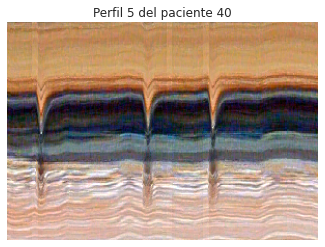

In [15]:
paciente = 40
corte = 5
img_slice = np.zeros((210,300,3), dtype='uint8')
red_channels = slices1[paciente+corte*5,0,0]
green_channels = slices1[paciente+corte*5,1,0]
blue_channels = slices1[paciente+corte*5,2,0]
img_slice[:,:,0] = red_channels[:,:,1]
img_slice[:,:,1] = green_channels[:,:,1]
img_slice[:,:,2] = blue_channels[:,:,1]

plt.imshow(img_slice)
plt.title('Perfil {} del paciente {}'.format(corte, paciente))
plt.axis('off')

# Load data set

In [16]:
path_data_sets = '/home/brayan/Documentos/datos_ojos' #Path of the data
data_sets = os.listdir(path_data_sets) #Datos .mat para realizar los calculos
print(data_sets)

['data3_IZQ_concatslcs.mat', 'results3_DER_concatslcs.mat', 'data3_DER_concatslcs.mat', 'results3_IZQ_concatslcs.mat']


In [17]:
eyes_for_model_binary = {} #Dictionary to save de array information 

for data_set in data_sets: #Iteration of all data

    data = reader.loadmat(path_data_sets + '/' + data_set) #Load de data set
    slices = data['concatslices'] #obtain information from a specific data set

    X,Y = get_data(slices) #Get array information

    eyes_for_model_binary[data_set] = (X,Y) #Add arrays to the dictionary using the name "data_set" as a key 

    del data,slices

for llave in eyes_for_model_binary.keys(): #Iterating the dictionary to view saved information

    print('Binary {}: X.shape:{}, Y.shape{}, Y.unique{}'.format(llave, eyes_for_model_binary[llave][0].shape,eyes_for_model_binary[llave][1].shape,                                                                                   np.unique(eyes_for_model_binary[llave][1])))

In [11]:
def get_model(metodo):

    model_CNN =  keras.models.Sequential()                                        

    model_CNN.add(keras.layers.Input(shape=(210,300,4)))                        

    model_CNN.add(keras.layers.Conv2D(filters=16,                          
                                    kernel_size=(5, 5),
                                    strides=(2,2),
                                    kernel_initializer=metodo))
    model_CNN.add(keras.layers.BatchNormalization())
    model_CNN.add(keras.layers.ReLU())

    model_CNN.add(keras.layers.Conv2D(filters=16,                             
                                    kernel_size=(3, 3),
                                    strides=(1,1),
                                    kernel_initializer=metodo))
    model_CNN.add(keras.layers.BatchNormalization())
    model_CNN.add(keras.layers.ReLU())

    model_CNN.add(keras.layers.Conv2D(filters=32,                               
                                    kernel_size=(3, 3),
                                    strides=(2,2),
                                    kernel_initializer=metodo))
    model_CNN.add(keras.layers.BatchNormalization())
    model_CNN.add(keras.layers.ReLU())

    model_CNN.add(keras.layers.Conv2D(filters=32,                           
                                    kernel_size=(3, 3),
                                    strides=(1,1),
                                    kernel_initializer=metodo))
    model_CNN.add(keras.layers.BatchNormalization())
    model_CNN.add(keras.layers.ReLU())

    model_CNN.add(keras.layers.Conv2D(filters=64,                                
                                    kernel_size=(3, 3),
                                    strides=(1,1),
                                    kernel_initializer=metodo))
    model_CNN.add(keras.layers.BatchNormalization())
    model_CNN.add(keras.layers.ReLU())

    model_CNN.add(keras.layers.MaxPooling2D(pool_size=(2, 2),               
                                          strides=(2,2)))
  
    model_CNN.add(keras.layers.Conv2D(filters=128,                             
                                    kernel_size=(1, 1),
                                    strides=(1,1),
                                    kernel_initializer=metodo))
    model_CNN.add(keras.layers.BatchNormalization())
    model_CNN.add(keras.layers.ReLU())

    model_CNN.add(keras.layers.DepthwiseConv2D(kernel_size=(3,3),
                        depthwise_initializer=metodo))                
    model_CNN.add(keras.layers.BatchNormalization())
    model_CNN.add(keras.layers.ReLU())

    model_CNN.add(keras.layers.MaxPooling2D(pool_size=(2, 2),              
                                          strides=(2,2)))
  
    model_CNN.add(keras.layers.Conv2D(filters=256,                             
                                    kernel_size=(1, 1),
                                    kernel_initializer=metodo))
    model_CNN.add(keras.layers.BatchNormalization())
    model_CNN.add(keras.layers.ReLU())

    model_CNN.add(keras.layers.DepthwiseConv2D(kernel_size=(3,3),
                        depthwise_initializer=metodo))               
    model_CNN.add(keras.layers.BatchNormalization())
    model_CNN.add(keras.layers.ReLU())

    model_CNN.add(keras.layers.MaxPooling2D(pool_size=(2, 2),             
                                          strides=(2,2)))
  
    model_CNN.add(keras.layers.DepthwiseConv2D(kernel_size=(3,3),
                        depthwise_initializer=metodo))         
    model_CNN.add(keras.layers.BatchNormalization())
    model_CNN.add(keras.layers.ReLU())

    model_CNN.add(keras.layers.DepthwiseConv2D(kernel_size=(2,5),
                        depthwise_initializer=metodo))             
    model_CNN.add(keras.layers.BatchNormalization())
    model_CNN.add(keras.layers.ReLU(name='embebed'))

    model_CNN.add(keras.layers.Dense(2, 
                                   activation='softmax',
                                   kernel_initializer=metodo))
    
    opt = keras.optimizers.Adam(lr=0.001)
    model_CNN.compile(optimizer=opt, loss='sparse_categorical_crossentropy',metrics=['acc'])
    
    return model_CNN

# Classification PK-Control

In [12]:
def getPartition(X, Y, init, end):
    
    X_1,Y_1 = X[:init,:,:,:],Y[:init]
    X_2,Y_2 = X[end:,:,:,:],Y[end:]
    X_train,Y_train = np.concatenate((X_1,X_2)),np.concatenate((Y_1,Y_2))

    X_test, Y_test = [], []
    X_3, Y_3 = X[init:end,:,:,:], Y[init:end]
    for index in original_data_index:
        X_test.append(X_3[index,:,:,:])
        Y_test.append(Y_3[index])            
    X_test, Y_test = np.array(X_test), np.array(Y_test)
    
    return X_train, Y_train, X_test, Y_test

In [13]:
def trainAndPredict(X_test, Y_test):
    
    Y_pred = model(X_test)
    y_pred = []
    for i in range(Y_pred.shape[0]):
        y_pred.append(np.argmax(Y_pred[i]))
    
    results = precision_recall_fscore_support(Y_test,y_pred, average='macro')
    
    print(results)
    return 0


In [14]:
# watch -n0 nvidia-smi <------- state of the gpu
patients = 26

for j, data_set in enumerate(data_sets):

    init = 0
    end = 80
    values = []
    
    for i in range(patients):

        model = get_model('lecun_normal')
        X, Y  = eyes_for_model_binary[data_set][0], eyes_for_model_binary[data_set][1]
        X_train, Y_train, X_test, Y_test = getPartition(X, Y, init, end)
         
        print('{}-Fold:{}/{}'.format(j,i,patients-1))

        history = model.fit(X_train, Y_train, epochs=25 ,verbose=0, batch_size=10,validation_data=(X_test, Y_test))

        acc = history.history['val_acc']
        
        acc = round(acc[-1],2)
        
        Y_pred = model.predict(X_test)
        y_pred = []
        for i in range(Y_pred.shape[0]):
            y_pred.append(np.argmax(Y_pred[i]))
        
        results = list(precision_recall_fscore_support(Y_test,y_pred,average='macro')[:3])
        results.append(acc)

        values.append(results)
        
        init = end
        end += 80
        
    means = np.round(np.mean(np.array(values),axis=0),2)
    stds = np.round(np.std(np.array(values),axis=0),2)
    
    classificationResults = classificationResults.append({'Data': data_set, 
                                                          'Precision':means[0], 'StdP':stds[0], 
                                                          'Recall':means[1],    'StdR':stds[1], 
                                                          'F1 score':means[2],  'StdF':stds[2], 
                                                          'Accuraci':means[3],  'StdA':stds[3]}, ignore_index=True) 

0-Fold:0/25
0-Fold:1/25
0-Fold:2/25
/home/brayan/anaconda3/envs/tensor/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
0-Fold:3/25
0-Fold:4/25
0-Fold:5/25
0-Fold:6/25
0-Fold:7/25
0-Fold:8/25
0-Fold:9/25
0-Fold:10/25
0-Fold:11/25
0-Fold:12/25
0-Fold:13/25
0-Fold:14/25
0-Fold:15/25
0-Fold:16/25
0-Fold:17/25
0-Fold:18/25
0-Fold:19/25
0-Fold:20/25
0-Fold:21/25
0-Fold:22/25
0-Fold:23/25
0-Fold:24/25
0-Fold:25/25
1-Fold:0/25
1-Fold:1/25
1-Fold:2/25
1-Fold:3/25
1-Fold:4/25
1-Fold:5/25
1-Fold:6/25
1-Fold:7/25
1-Fold:8/25
1-Fold:9/25
1-Fold:10/25
1-Fold:11/25
1-Fold:12/25
1-Fold:13/25
1-Fold:14/25
1-Fold:15/25
1-Fold:16/25
1-Fold:17/25
1-Fold:18/25
1-Fold:19/25
1-Fold:20/25
1-Fold:21/25
1-Fold:22/25
1-Fold:23/25
1-Fold:24/25
1-Fold:25/25
2-Fold:0/25
2-Fol

In [15]:
classificationResults.head(4)

Data  Precision  StdP  Recall  StdR  F1 score  StdF  \
0     data3_IZQ_concatslcs.mat       0.79  0.25    0.75  0.30      0.76  0.28   
1  results3_DER_concatslcs.mat       0.69  0.24    0.60  0.33      0.63  0.30   
2     data3_DER_concatslcs.mat       0.85  0.23    0.79  0.31      0.81  0.28   
3  results3_IZQ_concatslcs.mat       0.83  0.24    0.78  0.31      0.80  0.28   

   Accuraci  StdA  
0      0.93  0.12  
1      0.80  0.22  
2      0.90  0.18  
3      0.90  0.16

In [17]:
classificationResults.to_csv('dataframes_results/classificationResults.csv')

# Dominant eye cuantification and embedding space

In [8]:
def getPartition2(X, Y):

    original_data_index = [0, 4, 8, 16, 20, 24, 32, 36, 40, 48, 52, 56, 64, 68, 72, 80, 84, 88, 96, 100, 104, 112, 116, 120, 128, 132, 136, 144, 148, 152, 160, 164,                             168, 176, 180, 184, 192, 196, 200, 208, 212, 216, 224, 228, 232, 240, 244, 248, 256, 260, 264, 272, 276, 280, 288, 292, 296, 304, 308, 312,                           320, 324, 328, 336, 340, 344, 352, 356, 360, 368, 372, 376, 384, 388, 392, 400, 404, 408, 416, 420, 424, 432, 436, 440, 448, 452, 456, 464,                           468, 472, 480, 484, 488, 496, 500, 504, 512, 516, 520, 528, 532, 536, 544, 548, 552, 560, 564, 568, 576, 580, 584, 592, 596, 600, 608, 612,                           616, 624, 628, 632, 640, 644, 648, 656, 660, 664, 672, 676, 680, 688, 692, 696, 704, 708, 712, 720, 724, 728, 736, 740, 744, 752, 756, 760,                           768, 772, 776, 784, 788, 792]
    patients_test = 5 #For every class 
    #print(X.shape, Y.shape)
    X_train, Y_train = X[80*patients_test:-80*patients_test,:,:,:], Y[80*patients_test:-80*patients_test]
    X_1, Y_1 = X[:80*patients_test,:,:,:], Y[:80*patients_test]
    X_2, Y_2 = X[-80*patients_test:,:,:,:], Y[-80*patients_test:]
    X_3, Y_3 = np.concatenate((X_1, X_2)), np.concatenate((Y_1, Y_2))

    X_test, Y_test = [], []
    
    for index in original_data_index:

        X_test.append(X_3[index,:,:,:])
        Y_test.append(Y_3[index])

    X_test, Y_test = np.array(X_test), np.array(Y_test)
    
    #print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)
    return X_train, Y_train, X_test, Y_test

In [9]:
def eyeCuantification(X_left, Y_left, X_right, Y_right):

    dominant_prop = []
    not_dominant_prop = []
    dominant_eye = []
    not_dominant_eye = []
        
    count_left = 0
    count_right = 0
    model = get_model('lecun_normal')

    X_train_l, Y_train_l, X_test_l, Y_test_l = getPartition2(X_left, Y_left)

    #left_predict = model_left.predict(X_test_l)
    X_train_r, Y_train_r, X_test_r, Y_test_r = getPartition2(X_right, Y_right)

    X_train = np.concatenate((X_train_l, X_train_r))
    Y_train  = np.concatenate((Y_train_l, Y_train_r))

    X_test = np.concatenate((X_test_l, X_test_r))
    Y_test  = np.concatenate((Y_test_l, Y_test_r)) 

    model = get_model('lecun_normal')
    opt = keras.optimizers.Adam(lr=0.001)
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['acc'])

    history = model.fit(X_train, Y_train, epochs=8, verbose=0, batch_size=5,validation_data=(X_test, Y_test))

    right_predict = model.predict(X_test_r)
    left_predict = model.predict(X_test_l)
    #print(left_predict.shape, right_predict.shape)

    for i in range(150): 

        comparate_list = []

        if i<75:

            comparate_list.append(left_predict[i,0,0,0])
            comparate_list.append(right_predict[i,0,0,0])

        else:

            comparate_list.append(left_predict[i,0,0,1])
            comparate_list.append(right_predict[i,0,0,1])

        pos = comparate_list.index(max(comparate_list))

        if pos==0:

            dominant_prop.append(comparate_list[pos])
            dominant_eye.append(X_test_l[i,:,:,:])

            not_dominant_prop.append(comparate_list[1])
            not_dominant_eye.append(X_test_r[i,:,:,:])
            count_left += 1

        else:

            dominant_prop.append(comparate_list[pos])
            dominant_eye.append(X_test_r[i,:,:,:])

            not_dominant_prop.append(comparate_list[0])
            not_dominant_eye.append(X_test_l[i,:,:,:])
            count_right += 1
            
    dominant_eye = np.array(dominant_eye)
    dominant_prop = np.array(dominant_prop)
    not_dominant_eye = np.array(not_dominant_eye)
    not_dominant_prop = np.array(not_dominant_prop)

    return dominant_eye, dominant_prop, not_dominant_eye, not_dominant_prop, model
    #print('Dominant left:{}-Dominant right:{}'.format(count_left, count_right))


In [10]:
data_sets = [('magnifiedLeft.mat', 'magnifiedRight.mat'), ('originalLeft.mat', 'originalRight.mat')]
data_set_original = data_sets[1]
data_set_magnified = data_sets[0]

X_left_original, Y_left_original = eyes_for_model_binary[data_set_original[0]][0], eyes_for_model_binary[data_set_original[0]][1]
X_right_original, Y_right_original = eyes_for_model_binary[data_set_original[1]][0], eyes_for_model_binary[data_set_original[1]][1]
X_left_magnified, Y_left_magnified = eyes_for_model_binary[data_set_magnified[0]][0], eyes_for_model_binary[data_set_magnified[0]][1]
X_right_magnified, Y_right_magnified = eyes_for_model_binary[data_set_magnified[1]][0], eyes_for_model_binary[data_set_magnified[1]][1]

dominant_eye_o, dominant_prop_o, not_dominant_eye_o, not_dominant_prop_o, model_o = eyeCuantification(X_left_original, Y_left_original,
                                                                                                                   X_right_original, Y_right_original)
dominant_eye_m, dominant_prop_m, not_dominant_eye_m, not_dominant_prop_m, model_m = eyeCuantification(X_left_magnified, Y_left_magnified,                                                                                                                                   X_right_magnified, Y_right_magnified)

In [11]:
probabilities_generated = np.concatenate((dominant_prop_o, not_dominant_prop_o, dominant_prop_m, not_dominant_prop_m))
names_generated = np.concatenate((np.full((150,),'Dominant control'), 
                                  np.full((150,),'Not-dominant control'), 
                                  np.full((150,),'Magnified dominant'), 
                                  np.full((150,),'Magnified not-dominant')))
boxplotResults = pd.DataFrame({'Probability': probabilities_generated, 'Names':names_generated})
boxplotResults.head(10)

Probability             Names
0     0.926092  Dominant control
1     0.999004  Dominant control
2     0.999706  Dominant control
3     0.993788  Dominant control
4     0.999994  Dominant control
5     0.999989  Dominant control
6     0.744107  Dominant control
7     0.999988  Dominant control
8     0.999987  Dominant control
9     0.999996  Dominant control

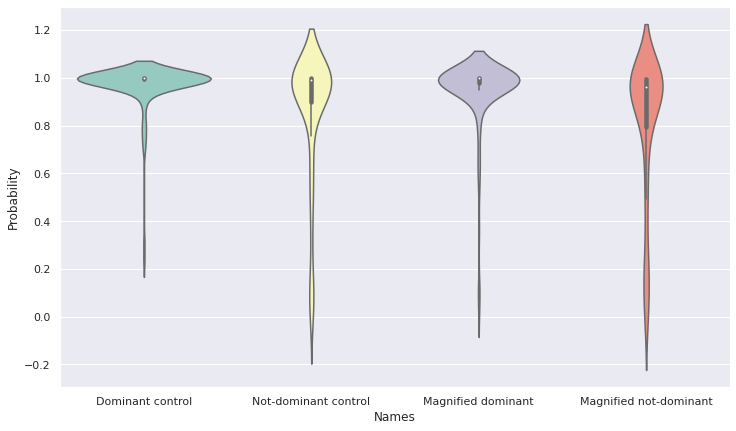

In [12]:
plt.figure(figsize=(12,7))
ax = sns.violinplot(x="Names", y="Probability", data=boxplotResults, palette="Set3")
plt.savefig("Images/violingPlot.pdf")

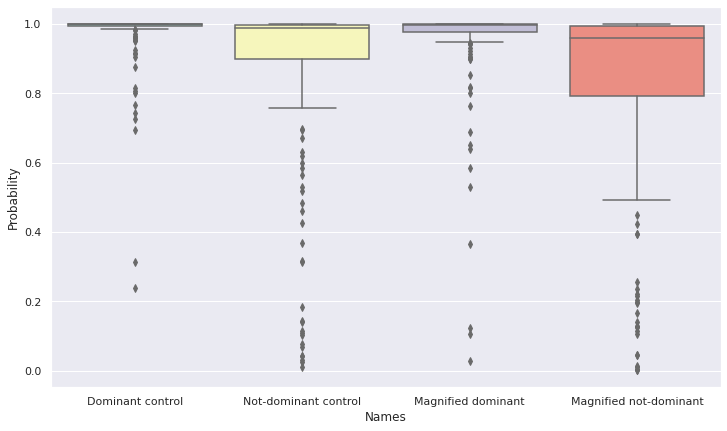

In [13]:
plt.figure(figsize=(12,7))
ax = sns.boxplot(x="Names", y="Probability", data=boxplotResults, palette="Set3")
plt.savefig("Images/boxplot.pdf")

## Nonparametric Statistical Significance Tests

In [14]:
def makeDesicion(p, alpha):
    if p > alpha:
        print('Same distribution (fail to reject H0)')
    else:
        print('Different distribution (reject H0)')

### Mann-Whitney U Test

In [15]:
alpha = 0.05
stat, p = mannwhitneyu(dominant_prop_o, dominant_prop_m)
print('Statistics=%.3f, p=%.3f' % (stat, p))
makeDesicion(p, alpha)

Statistics=8728.000, p=0.000
Different distribution (reject H0)


In [16]:
alpha = 0.05
stat, p = mannwhitneyu(not_dominant_prop_o, not_dominant_prop_m)
print('Statistics=%.3f, p=%.3f' % (stat, p))
makeDesicion(p, alpha)

Statistics=8720.000, p=0.000
Different distribution (reject H0)


### Wilcoxon Signed-Rank Test

In [17]:
alpha = 0.05
stat, p = wilcoxon(dominant_prop_o, dominant_prop_m)
print('Statistics=%.3f, p=%.3f' % (stat, p))
makeDesicion(p, alpha)

Statistics=3626.000, p=0.000
Different distribution (reject H0)


In [18]:
alpha = 0.05
stat, p = wilcoxon(not_dominant_prop_o, not_dominant_prop_m)
print('Statistics=%.3f, p=%.3f' % (stat, p))
makeDesicion(p, alpha)

Statistics=4469.000, p=0.025
Different distribution (reject H0)


## Embedding space

In [19]:
def comvertir(eyes, capa):
    
    array = capa.predict(eyes)

    return array[:,0,0,:]

def meanNorm(data):
    
    meanX = np.mean(data[:,0])
    meanY = np.mean(data[:,1])
    
    data[:,0] -= meanX
    data[:,1] -= meanY
    
    return data


In [20]:
capa_o = tf.keras.models.Model(inputs=model_o.input, outputs=model_o.get_layer('embebed').output)
capa_m = tf.keras.models.Model(inputs=model_m.input, outputs=model_m.get_layer('embebed').output)

dominant_eye_embebed = comvertir(dominant_eye_o, capa_o)
dominant_eye_aumented_embebed = comvertir(dominant_eye_m, capa_m)

not_dominant_eye_embebed = comvertir(not_dominant_eye_o, capa_o)
not_dominant_eye_aumented_embebed = comvertir(not_dominant_eye_m, capa_m)

print(dominant_eye_embebed.shape, dominant_eye_aumented_embebed.shape, not_dominant_eye_embebed.shape, not_dominant_eye_aumented_embebed.shape)

(150, 256) (150, 256) (150, 256) (150, 256)


In [21]:
dominant_N = TSNE(n_components=2)
dominant_A = TSNE(n_components=2)
not_dominant_N = TSNE(n_components=2)
not_dominant_A = TSNE(n_components=2)

In [22]:
ojos_dominante_N_T = meanNorm(dominant_N.fit_transform(dominant_eye_embebed))
ojos_dominante_A_T = meanNorm(dominant_A.fit_transform(dominant_eye_aumented_embebed))
ojos_recesivo_N_T = meanNorm(not_dominant_N.fit_transform(not_dominant_eye_embebed))
ojos_recesivo_A_T = meanNorm(not_dominant_A.fit_transform(not_dominant_eye_aumented_embebed))


print(ojos_dominante_N_T.shape)
print(ojos_dominante_A_T.shape)
print(ojos_recesivo_N_T.shape)
print(ojos_recesivo_A_T.shape)

(150, 2)
(150, 2)
(150, 2)
(150, 2)


In [23]:
label = []
for i in range(150):
    if i < 75:
        label.append('Control')
    else:
        label.append('Parkinson')


data = np.concatenate((ojos_dominante_N_T, ojos_dominante_A_T, ojos_recesivo_N_T, ojos_recesivo_A_T))

typeD = np.concatenate((np.full((150,),'Dominant original'), 
                                  np.full((150,),'Dominant magnified'), 
                                  np.full((150,),'Not dominant original'), 
                                  np.full((150,),'Not dominant magnified')))

embeddingResults = pd.DataFrame({'X':data[:,0], 'Y':data[:,1],
                                 'Data':typeD , 'Label':np.concatenate((label,label,label,label))})

embeddingResults.head(10)

X          Y               Data    Label
0 -3.067470   0.889118  Dominant original  Control
1 -2.891365   7.883558  Dominant original  Control
2 -8.245225   6.890803  Dominant original  Control
3 -3.489463   0.756930  Dominant original  Control
4 -1.766859   8.079423  Dominant original  Control
5 -3.180467  10.665919  Dominant original  Control
6 -2.304167  -0.239800  Dominant original  Control
7 -1.696516   8.032430  Dominant original  Control
8 -3.060205  10.707808  Dominant original  Control
9 -4.320560   0.841173  Dominant original  Control

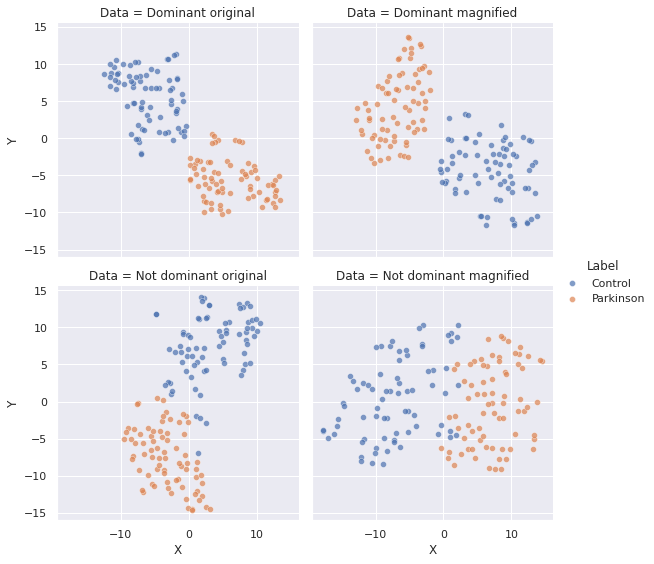

In [24]:
g = sns.FacetGrid(embeddingResults, col="Data", hue="Label", col_wrap=2, height=4)
g.map(sns.scatterplot, "X", "Y", alpha=.7)
g.add_legend()
plt.savefig("Images/Emdeddin-space.pdf")